<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Extended-Functional-Groups-(EFGs)" data-toc-modified-id="Extended-Functional-Groups-(EFGs)-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Extended Functional Groups (EFGs)</a></span><ul class="toc-item"><li><span><a href="#Obtain-EFGs-from-a-dataset" data-toc-modified-id="Obtain-EFGs-from-a-dataset-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Obtain EFGs from a dataset</a></span></li><li><span><a href="#Decompose-a-molecule-based-on-current-vocabulary" data-toc-modified-id="Decompose-a-molecule-based-on-current-vocabulary-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Decompose a molecule based on current vocabulary</a></span></li></ul></li></ul></div>

# Extended Functional Groups (EFGs)

## Obtain EFGs from a dataset

In [1]:
# Load data
import torch
qm9 = torch.load('QM9smiles.pt')

Check the version:

In [2]:
import EFGs
EFGs.__version__

'0.8.2'

First those molecules would go through initial fragmentation:
<br>
* mol2frag helps to find fragments in molecules
* counter is a small tool to store vocabulary as `{EFG:frequency}` format

Below is just one example with explicit Hs been taken into consideration. There are lots of available options:
```python
def mol2frag(raw_mol, TreatHs='ignore', returnidx=False, toEnd=False, vocabulary=(), extra_included=False, isomericSmiles=True, UnknownIdentity=False, extra_backup={})
    '''
    raw_mol: rdkit mol object to be decompose
    TreatHs: The way to treat Hs. Default: 'ignore' (Other options: 'separate': treat Hs separately; 'include': merged to neighboring EFGs) 
    returnidx: Whether cooresponding atom index of EFGs shouls be returned. (Default=False)
    toEnd: Whether to decompose to the end. (Default=False, will only do 1-step decomposition)
    vocabulary: A list of smiles which contains EFGs. This argument would be ignore if toEnd=False. If toEnd is set to True, this argument is required. (Default=None)
    extra_included: If fragments outside of vocabulary should be parsed. (Default=False, will throw an error if a fragment cannot be found in vocabulary). When it is set to True, additional fragments would be simply classified based on their aromaticity.
    extra_backup: If an empty dictionary is provided, additional fragnents' smiles would be added. 
    return:
    Functional groups' smiles (or 'Aromatic'/'Non-aromatic') and C/Hs
    (or)
    Functional groups' smiles (or 'Aromatic'/'Non-aromatic'), C/Hs, atom indices of funtional groups
    and CHs (if returnidx=True)
    '''
```

In [4]:
from rdkit import Chem
from EFGs import mol2frag, counter
word = {}
for smiles in qm9:
    mol = Chem.MolFromSmiles(smiles)
    a,b=mol2frag(mol, TreatHs='include', isomericSmiles=False)
    for fg in a+b:
        counter(fg, word)

We can save a total vocabulary library:

In [5]:
torch.save(word, 'initial_vocab.pt')

In [6]:
len(word)

2681

The initial vocabulary is way too large, let's do further fragmentation for those low frequency EFGs:

The default value for a parameter alpha is 0.7, which means those EFGs ranking after 0.7\*len(vocab) would be further decompose.
```python
def cleavage(dictionary, alpha = 0.7, isomericSmiles=True)
```

In [7]:
from EFGs import cleavage
cleavage(word, isomericSmiles=False)

In [8]:
len(word)

1186

So here we got our final vocabulary.

In [14]:
qm9[1904]

'CC12CC1C(=O)O2'

In [10]:
torch.save(word, 'vocab_cut0.7.pt')

## Decompose a molecule based on current vocabulary

We will still use the same function: mol2frag

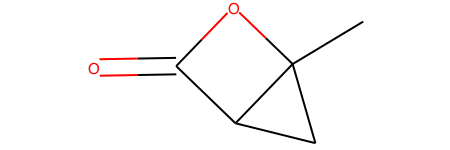

In [15]:
from rdkit.Chem.Draw import IPythonConsole
mol = Chem.MolFromSmiles('CC12CC1C(=O)O2')
mol

The function can also return atom index if returnidx=True. Note that the vocabulary inputs have to be a list.

In [17]:
mol2frag(mol, returnidx=True, vocabulary=list(word), toEnd=True, extra_included=True, TreatHs='include', isomericSmiles=False)

(['O=CO'],
 ['C010', 'C040', 'C020', 'C030'],
 [(4, 5, 6)],
 [(0,), (1,), (2,), (3,)])